In [85]:
import DataLoader
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import numpy as np

In [33]:
ImgSize = (64, 64)
TrainDs, ValDs, Classes = DataLoader.LoadData(ImgSize)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 992 files belonging to 2 classes.
Using 198 files for validation.


In [34]:
Model = tf.keras.models.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Rescaling(
            1.0 / 255, input_shape=(ImgSize[0], ImgSize[1], 3)
        ),
        tf.keras.layers.Conv2D(16, (2,2), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(32, (2,2), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [35]:
Model.compile(
    optimizer="adam",
    loss=tf.keras.losses.binary_crossentropy,
    metrics=["accuracy"],
)
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        208       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        2080      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)       

In [36]:
epochs = 10
print(f"\nTraining model for {epochs} Epochs\n")

checkpoint_path = "training"
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_dir = os.path.join(checkpoint_path, "cp-{epoch:04d}.ckpt")

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq="epoch")

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=2
)



Training model for 10 Epochs



In [37]:
History = Model.fit(
    TrainDs,
    validation_data=ValDs,
    epochs=epochs,
    verbose = 2,
    callbacks=[cp_callback, es_callback] 
)

Epoch 1/10



Epoch 1: saving model to training
250/250 - 11s - loss: 0.4262 - accuracy: 0.8761 - val_loss: 0.3588 - val_accuracy: 0.8990 - 11s/epoch - 46ms/step
Epoch 2/10

Epoch 2: saving model to training
250/250 - 10s - loss: 0.3217 - accuracy: 0.9503 - val_loss: 0.2895 - val_accuracy: 0.9495 - 10s/epoch - 40ms/step
Epoch 3/10

Epoch 3: saving model to training
250/250 - 8s - loss: 0.2713 - accuracy: 0.9639 - val_loss: 0.2527 - val_accuracy: 0.9495 - 8s/epoch - 34ms/step
Epoch 4/10

Epoch 4: saving model to training
250/250 - 8s - loss: 0.2208 - accuracy: 0.9785 - val_loss: 0.1987 - val_accuracy: 0.9798 - 8s/epoch - 33ms/step
Epoch 5/10

Epoch 5: saving model to training
250/250 - 9s - loss: 0.1817 - accuracy: 0.9861 - val_loss: 0.1708 - val_accuracy: 0.9848 - 9s/epoch - 35ms/step
Epoch 6/10

Epoch 6: saving model to training
250/250 - 10s - loss: 0.1522 - accuracy: 0.9906 - val_loss: 0.1496 - val_accuracy: 0.9798 - 10s/epoch - 39ms/step


In [53]:
FinalDS = tf.keras.preprocessing.image_dataset_from_directory(
    "Face Mask Dataset/Validation",
    seed=123,
    image_size=ImgSize, batch_size=1)

Found 800 files belonging to 2 classes.


In [71]:
true_labels = list()
pred_labels = list()

for batch in FinalDS:
    image, label = batch
    pred = np.array(Model.predict(image, verbose=0) > 0.5, dtype=np.int32).reshape(-1,)
    true_labels.append(label.numpy())
    pred_labels.append(pred)
print("Done")

Done


In [75]:
true_labels = np.array(true_labels).reshape(-1,)

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [77]:
pred_labels = np.array(pred_labels).reshape(-1,)

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [78]:
confusion_matrix(true_labels, pred_labels)

array([[393,   7],
       [  2, 398]], dtype=int64)

In [84]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.98      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



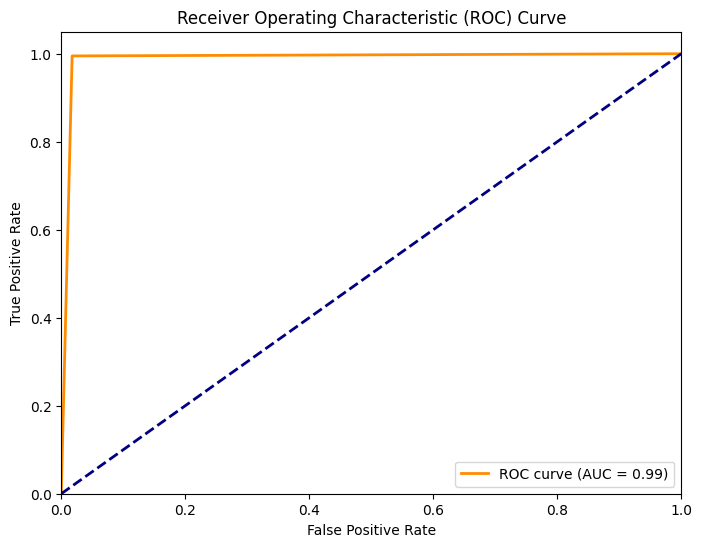

In [86]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()